# Create animations from time raster time series

## Content
* In this section we will
* work with MODIS satellite data and environmental data (e.g. WorldClim) and analyze temporal patterns
* loop over datasets to create a vegetation index time series
* plot time series for individual places
* create an animation to visualize the seasonal patterns of vegetation indices
* compare seasonal patterns of vegetation indices with climate variability


## Assignments
* calculate the max NDVI across months (peak season)
* Test the workflow below other vegetation indices (e.g. the normalized difference water index)
    * See a list of indices for MODIS here: https://github.com/awesome-spectral-indices/awesome-spectral-indices
* Create an animation for the VOD data (vertical optical depth data, VODCA dataset)
* try to animate the NDVI and the VOD (VODCA) data side by side and add a scatterplot
* Calculate the yearly standard deviation (instead of the mean) of NDVI or VOD data and correlate it with WorldClim climate data (e.g. temperature or precipiation seasonality)
    * Is there are relationship between temporal dynamics and biomes?
* Can you create a 3D plot where the world turns around? See an example I did in R a while ago and it would be nice to do that in pyton:
    * https://drive.google.com/file/d/1aTyBlfu78kbn7ZI6FxysSnNWzvH-oE0D/view?usp=sharing
    * https://drive.google.com/file/d/1BWVVKwDsgQMOvk9FZGUPIXYrp_VfN-UJ/view?usp=sharing
    * Maybe this here is a good start: https://stackoverflow.com/questions/17365364/plotting-cylindrical-map-data-over-a-3d-sphere
    * Also consider to ask ChatGPT or Copilot for advice :-)


## Load packages, etc.

In [1]:
import rioxarray
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import xarray as xr
import glob
import os
from geopy.geocoders import Nominatim
from scipy.stats import spearmanr

In [2]:
# Set the path to our working directory (where your data is stored)
working_directory = "G:/My Drive/teaching/2024_msc_remotesensing_geoinformatics/"
os.chdir(working_directory)

## List the multitemporal files

In [3]:
raster_files = glob.glob('data/earth_obseration_products/modis_res/2000-2020/0.01_deg/*.tif')
[raster_files[:5], raster_files[-5:]]

[['data/earth_obseration_products/modis_res/2000-2020/0.01_deg\\2000-2020_sur_refl_multiyear_mean_m10_band01.tif',
  'data/earth_obseration_products/modis_res/2000-2020/0.01_deg\\2000-2020_sur_refl_multiyear_mean_m10_band02.tif',
  'data/earth_obseration_products/modis_res/2000-2020/0.01_deg\\2000-2020_sur_refl_multiyear_mean_m10_band03.tif',
  'data/earth_obseration_products/modis_res/2000-2020/0.01_deg\\2000-2020_sur_refl_multiyear_mean_m10_band04.tif',
  'data/earth_obseration_products/modis_res/2000-2020/0.01_deg\\2000-2020_sur_refl_multiyear_mean_m10_band05.tif'],
 ['data/earth_obseration_products/modis_res/2000-2020/0.01_deg\\2000-2020_sur_refl_multiyear_mean_m9_band01.tif',
  'data/earth_obseration_products/modis_res/2000-2020/0.01_deg\\2000-2020_sur_refl_multiyear_mean_m9_band02.tif',
  'data/earth_obseration_products/modis_res/2000-2020/0.01_deg\\2000-2020_sur_refl_multiyear_mean_m9_band03.tif',
  'data/earth_obseration_products/modis_res/2000-2020/0.01_deg\\2000-2020_sur_refl

## Loop through all files and calculate the NDVI

In [4]:
# from a file list (raster_files) select the "band01" and "band04" of each month (m1, m2, etc.) to calculate the NDVI and append it to a list.

# Define the months
months = [f'm{i}' for i in range(1, 13)]

# Calculate NDVI for each month
ndvi_list = []
for month in months:
    # Find the files for the current month and band
    band01_file = next((file for file in raster_files if f'_{month}_' in file and '_band01.' in file), None)
    band02_file = next((file for file in raster_files if f'_{month}_' in file and '_band02.' in file), None)

    if band01_file and band02_file:
        # Load the red and NIR bands and (optionally) coarsen the data
        red = rioxarray.open_rasterio(band01_file).squeeze()#.coarsen(x=40, y=40).mean()
        nir = rioxarray.open_rasterio(band02_file).squeeze()#.coarsen(x=40, y=40).mean()

        # Calculate the NDVI
        ndvi = (nir - red) / (nir + red)

        # Append the NDVI raster to the list
        ndvi_list.append(ndvi)

In [5]:
# test the length of the ndvi_list
len(ndvi_list)

12

In [6]:
# extract point values of ndvi_list at a specific location (e.g. lat=52.52, lon=13.40) and plot them as a time series

# Define the location
#lat, lon = 52.52, 13.40
#location = xr.Dataset()
#location["latitude"] = 52.52
#location["longitude"] = 13.40

# define the location using text prompt
# Initialize Nominatim API
geolocator = Nominatim(user_agent="MyApp")
# enter a city name or region
location = geolocator.geocode(input("Enter a city or region: ")) # e.g. Zugspitze, Freiburg; Amazon Rainforest; Fjordland, New Zealand; etc.

# extract the point values
ndvi_values = [ndvi.sel(x=location.longitude, y=location.latitude, method='nearest').values for ndvi in ndvi_list]
# plot the time series
plt.plot(ndvi_values)
plt.xlabel('Month')
plt.ylabel('NDVI')
plt.ylim(0, 1)
plt.show()

AttributeError: 'NoneType' object has no attribute 'longitude'

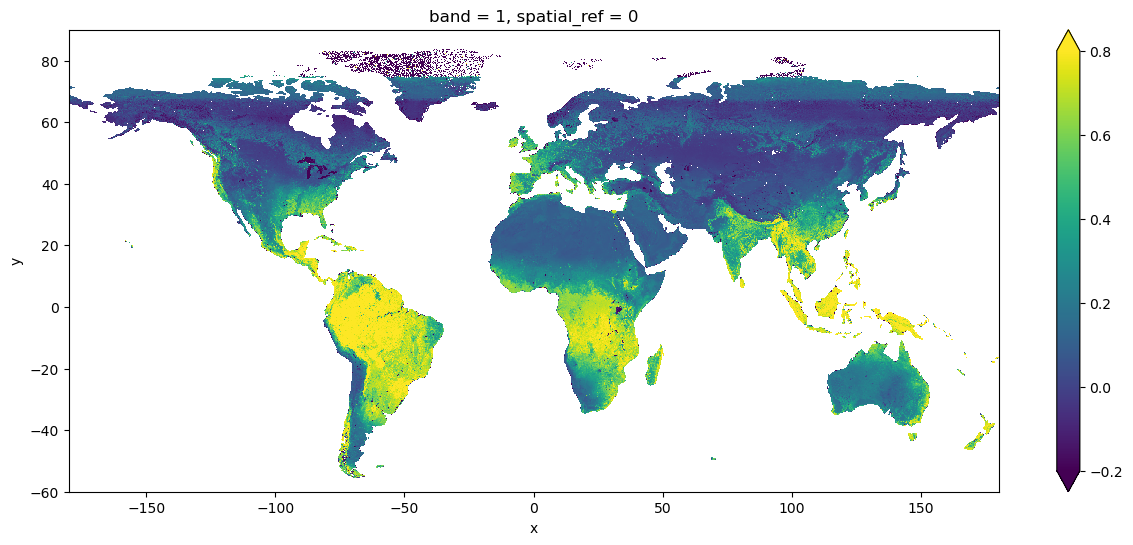

In [ ]:
# Create a testplot of the output of the first NDVI raster from -1 to 1
plt.figure(figsize=(15, 6)) # Set the figure size
ndvi_list[0].where(ndvi_list[0] != 0).plot(vmin=-0.2, vmax=0.8)

## Create an endless animation of the monthly NDVI layers

MovieWriter imagemagick unavailable; using Pillow instead.


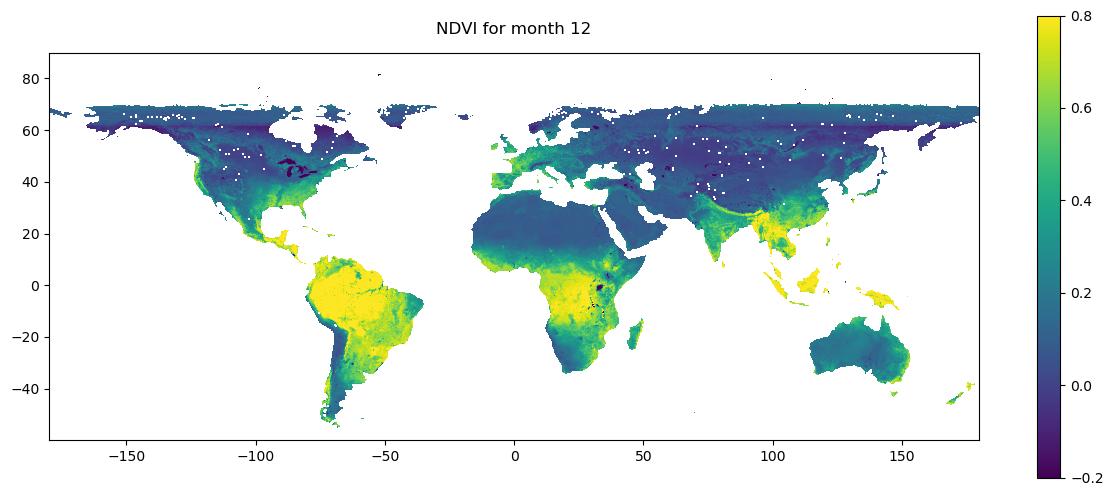

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(15, 6))

# Create a colormap that assigns the color white to the value NaN
cmap = plt.cm.viridis  # or any other colormap
cmap.set_bad('white')

# Create a list of images
ims = []
for i, raster in enumerate(ndvi_list, start=1):
    data = raster.where(raster != 0)
    extent = [raster.x.min(), raster.x.max(), raster.y.min(), raster.y.max()]
    im = ax.imshow(data, animated=True, vmin = -0.2, vmax = 0.8, extent=extent, cmap=cmap)
    title = ax.text(0.5,1.05,f"NDVI for month {i}", size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax.transAxes, )
    ims.append([im, title])

# Create the animation
ani = animation.ArtistAnimation(fig, ims, interval=300, blit=True)

# Add a colorbar
plt.colorbar(im, ax=ax)

# Save the animation
os.makedirs("exports", exist_ok=True)
ani.save('exports/animation_ndvi_per_month.gif', writer='imagemagick')

plt.show()

In [ ]:
combined = xr.concat(ndvi_list, dim='raster')
combined.shape

(12, 750, 1800)

c:\Users\teja\miniforge3\envs\msc_remote_sens_2024\lib\site-packages\numpy\lib\nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
c:\Users\teja\miniforge3\envs\msc_remote_sens_2024\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


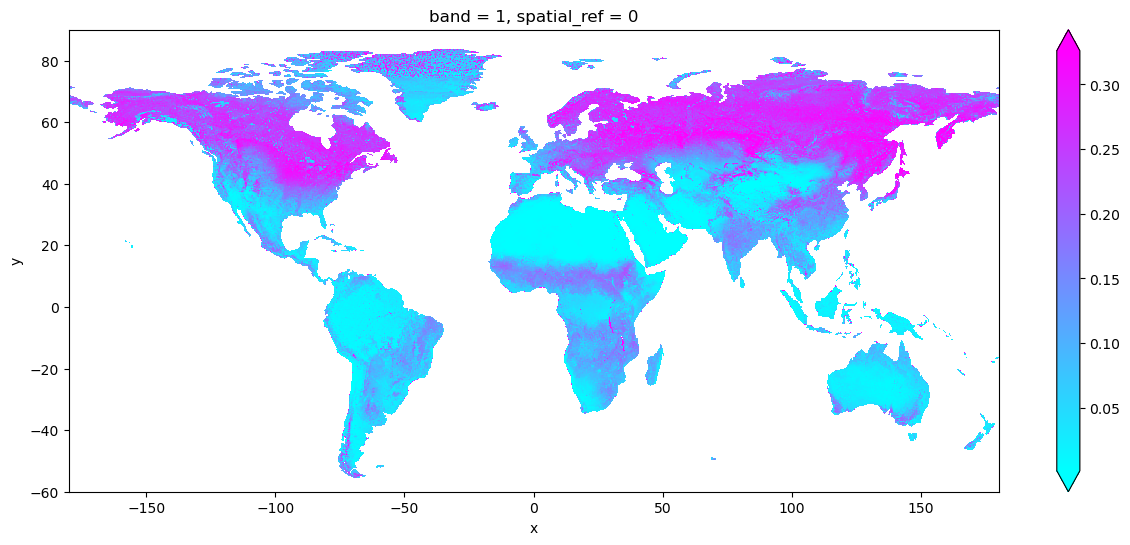

In [ ]:
# Calculate the pixel-wise standard deviation
ndvi_std_dev = combined.std(dim='raster')

plt.figure(figsize=(15, 6))
ndvi_std_dev.where(ndvi_std_dev != 0).plot(vmin=ndvi_std_dev.quantile(0.01), vmax=ndvi_std_dev.quantile(0.99), cmap='cool')

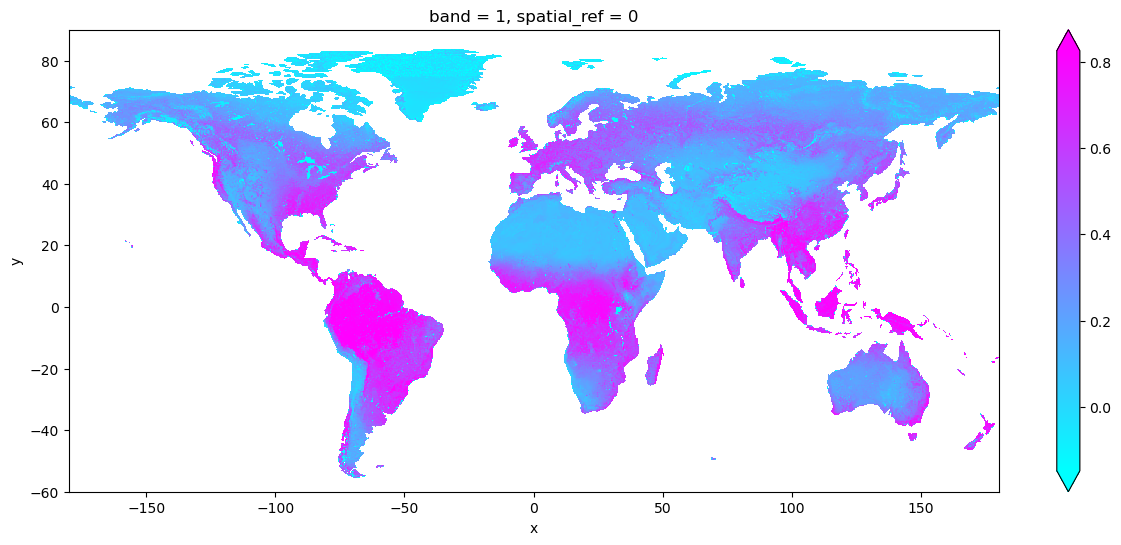

In [ ]:
# Calculate the pixel-wise mean
ndvi_mean = combined.mean(dim='raster')

plt.figure(figsize=(15, 6))
ndvi_mean.where(ndvi_mean != 0).plot(vmin=ndvi_mean.quantile(0.01), vmax=ndvi_mean.quantile(0.99), cmap='cool')

## Compare NDVI variability with climate and soil data
* Information on the climate variables can be found here: https://www.worldclim.org/data/bioclim.html
    * BIO1 = Annual Mean Temperature
    * BIO4 = Temperature Seasonality (standard deviation ×100)
    * BIO12 = Annual Precipitation
    * ...
* What are the strongest relationships?

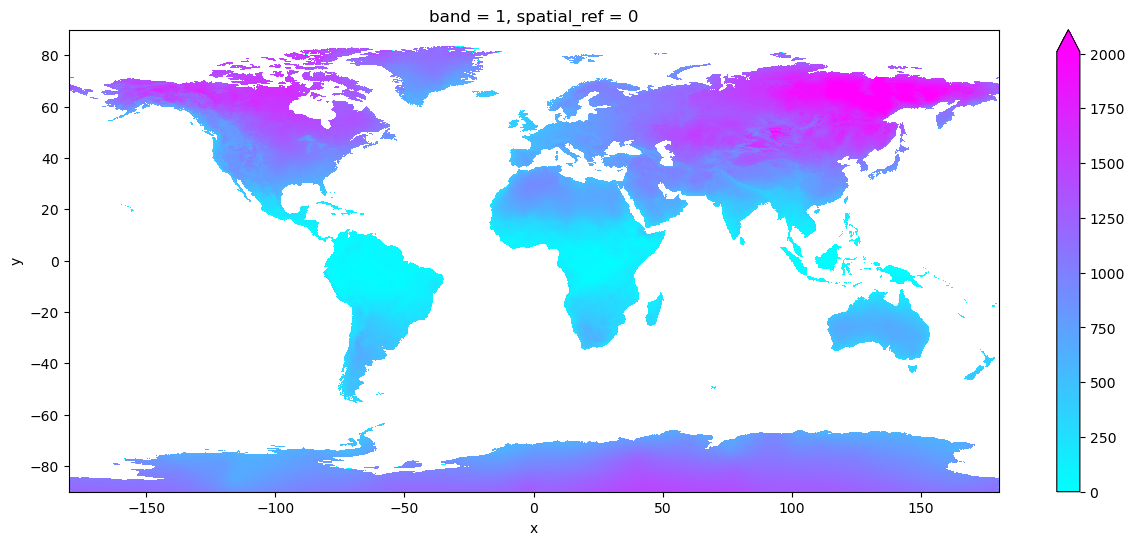

In [ ]:

temp_annual = rioxarray.open_rasterio("data/earth_obseration_products/worldclim_res/bio/0.01_deg/wc2.1_0.01_deg_bio_4.tif", masked = True)#.coarsen(x=40, y=40, boundary='trim').mean()
plt.figure(figsize=(15, 6))
temp_annual.plot(cmap='cool', vmin=0, vmax=temp_annual.quantile(0.99))

In [ ]:
print(ndvi_std_dev.shape) # layer, rows, columns
print(temp_annual.shape) # layer, rows, columns

(750, 1800)
(1, 900, 1800)


In [ ]:
temp_annual_reprojected = temp_annual.rio.reproject_match(ndvi_std_dev)

In [ ]:
temp_annual.max

<bound method DataArrayAggregations.max of <xarray.DataArray (band: 1, y: 900, x: 1800)> Size: 6MB
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [1206.8932, 1205.5115, ..., 1141.5636, 1142.1445],
        [1213.7256, 1214.029 , ..., 1148.5042, 1149.3837]]], dtype=float32)
Coordinates:
  * band         (band) int32 4B 1
  * x            (x) float64 14kB -179.9 -179.7 -179.5 ... 179.5 179.7 179.9
  * y            (y) float64 7kB 89.9 89.7 89.5 89.3 ... -89.3 -89.5 -89.7 -89.9
    spatial_ref  int32 4B 0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  2382.5246582031
    STATISTICS_MEAN:     nan
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   nan
    scale_factor:        1.0
    add_offset:          0.0>

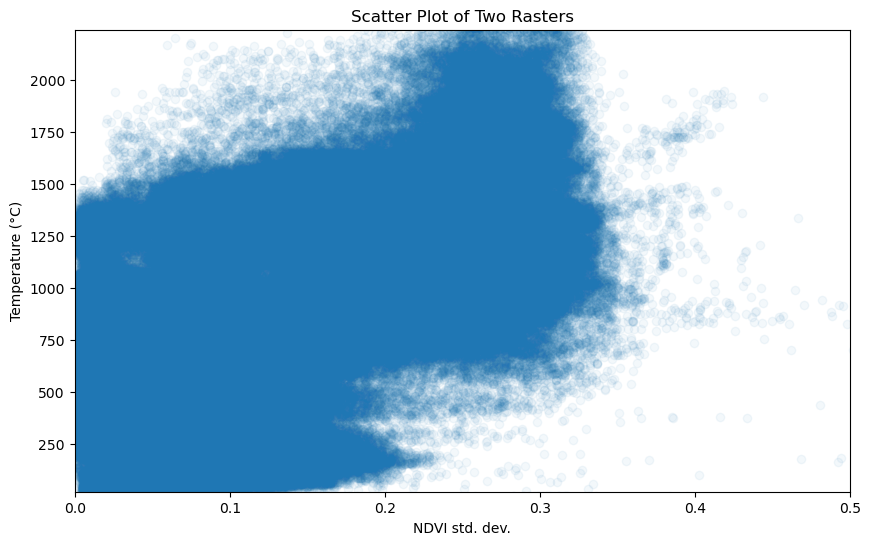

In [ ]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(ndvi_std_dev, temp_annual_reprojected, alpha=0.05)
plt.xlabel('NDVI std. dev.')
plt.ylabel('Temperature (°C)')
plt.title('Scatter Plot of Two Rasters')
plt.xlim(0, 0.5)
plt.ylim(temp_annual.quantile(0.001), temp_annual.quantile(0.999) )

plt.show()

In [72]:
import numpy as np

# Convert the rasters to numpy arrays
raster1_values = ndvi_std_dev.values
raster2_values = temp_annual_reprojected.values

# Flatten the arrays into 1D arrays
raster1_values = raster1_values.flatten()
raster2_values = raster2_values.flatten()

# Create a mask that selects only the non-NaN, non-zero and non-inf values
mask = (~np.isnan(raster1_values) & ~np.isnan(raster2_values) & ~np.isinf(raster1_values) & ~np.isinf(raster2_values)) & (raster1_values != 0) & (raster2_values != 0)

# Apply the mask to the data
raster1_values = raster1_values[mask]
raster2_values = raster2_values[mask]

# Calculate the correlation
correlation_matrix = np.corrcoef(raster1_values, raster2_values)

# The correlation coefficient is the value at position [0, 1] or [1, 0] in the correlation matrix


print("Pearson's correlation coefficient", round(correlation_matrix[0,1], 3))
print("Spearman's correlation coefficient", round(spearmanr(raster1_values, raster2_values)[0], 3))



Pearson's correlation coefficient 0.473
Spearman's correlation coefficient 0.597


So the NDVI variation is largely driven by temperature variation. The higher value for Spearmans correlation coefficient indicates that the relationship is monotonic, but not necessarily linear.

https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient